# Import and define the necessary methods

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import re
import os

def make_splits(start, interval, time_before, time_after, measurements_count):
    splits = []
    if(measurements_count>0):
        splits.append((start - timedelta(seconds=time_before), start + timedelta(seconds=time_after)))
        splits.extend(make_splits(start + timedelta(seconds=interval),interval, time_before, time_after, measurements_count-1))
    return splits

def assign_range(times, splits):
    c_ix = 0
    in_split = False
    ranges = []
    for index, time in times.iteritems():
        if(splits[c_ix][0] <= time <= splits[c_ix][1]):
            in_split = True
        elif(in_split == True):
            if(c_ix +1 < len(splits)):
                c_ix += 1
            in_split = False

        if(in_split):
            ranges.append(str(splits[c_ix]))
        else:
            ranges.append(None)
    ranges = np.array(ranges)
    return ranges

def window_rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))


# Define variables

In [2]:
recordings_file = './Recordings/January 15/Starts_at_17.31.50.txt'
target_file = './Recordings/January 15/ralf_answers.txt'

start_datetime = datetime(year=2020, month=1, day=15, hour=17,
                          minute=31, second=50)
interval = 10
time_before = 1
time_after = 3

# Data preprocessing

C:\Users\rtambets\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\rtambets\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


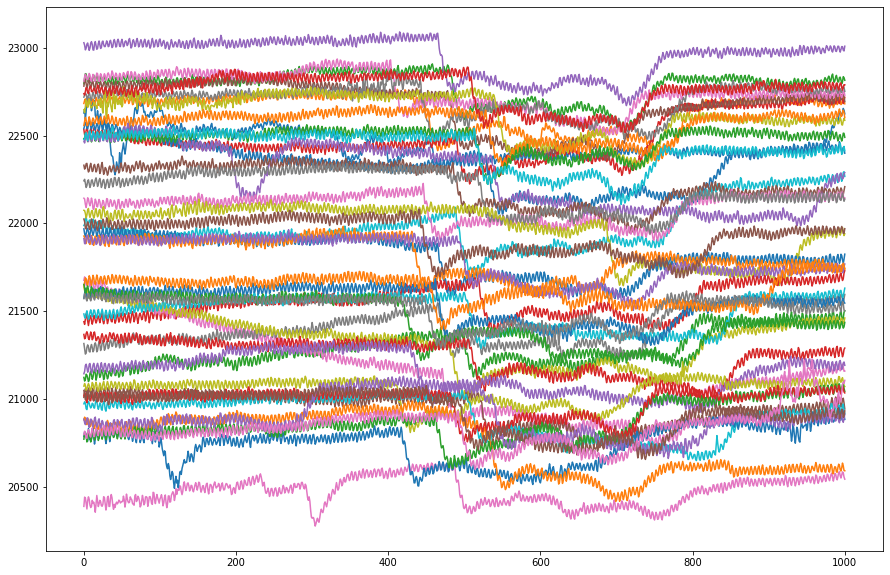

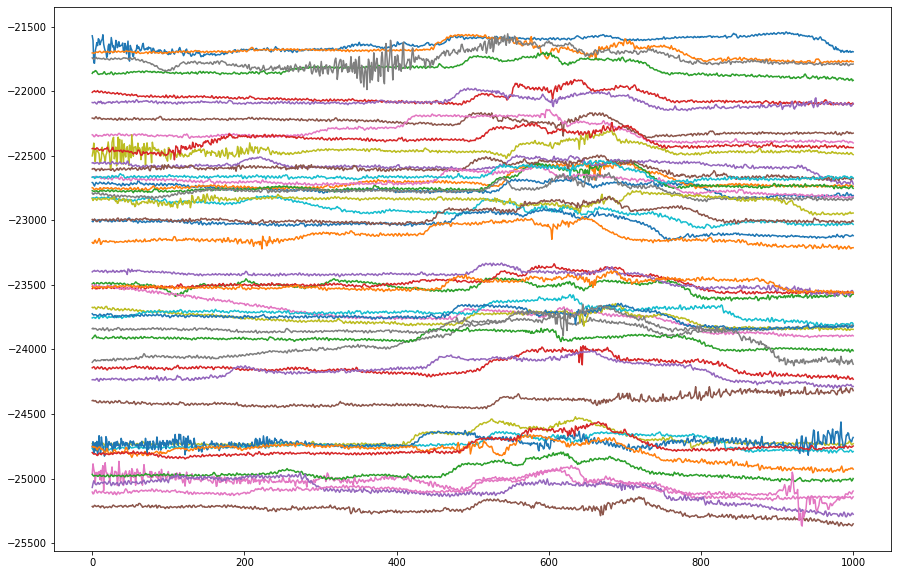

In [3]:
with open(target_file, 'r') as file:
    lines = file.readlines()

pattern = r'(\D)\s(\D)\n?'
joined_lines = "\n".join(lines)
meta_raw = re.findall(pattern,joined_lines)
meta_raw = np.array([list(m)for m in meta_raw])
meta_raw = meta_raw.T

#truth or false
decision = meta_raw[0]

# yes or no
action = meta_raw[1]

meta = np.ones(meta_raw.shape, dtype=bool)
meta[0] = meta_raw[0] == 'T'
meta[1] = meta_raw[1] == 'J'

measurements_count = meta.shape[1]

data = pd.read_csv(recordings_file, skiprows=6, delimiter=",", names=np.arange(13))
data = data.reset_index()
data['datetime'] = data[12].apply(lambda x: datetime.fromtimestamp(x/1000.0))

#siin vaata, mis kanalil brow ja mis kanalil cheek oli
data = data[[2,3,5,'datetime']]
data.columns = ["unrailed","brow", "cheek", "datetime"]

### Assign timestamps into ranges
splits = make_splits(start_datetime, interval, time_before, time_after, measurements_count)

data['ranges'] = assign_range(data['datetime'], splits)

groups = data.groupby('ranges')
groups_min = groups.size().min()

cheek_array = groups['cheek'].apply(lambda x: x.head(groups_min)).values
cheek_array = cheek_array.reshape(len(groups), groups_min)

brow_array = groups['brow'].apply(lambda x: x.head(groups_min)).values
brow_array = brow_array.reshape(len(groups), groups_min)


fig, ax = plt.subplots(figsize=(15,10))
for i in cheek_array:
    ax.plot(i)
fig.show()

fig, ax = plt.subplots(figsize=(15,10))

for i in brow_array:
    ax.plot(i)
fig.show()

In [4]:
cheek_array.shape

(47, 1001)

# Save files

In [5]:
# subject = len(os.listdir('./Processed_data/Cheek/'))
subject = 'ralf'

with open("./Processed_data/Cheek/{}".format(subject), 'wb') as file:
    np.save(file, cheek_array)
    
with open("./Processed_data/Brow/{}".format(subject), 'wb') as file:
    np.save(file, brow_array)
    
with open("./Processed_data/Decisions/{}".format(subject), 'wb') as file:
    np.save(file, meta)
    

# Read in files

(60, 1000)


C:\Users\rtambets\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\rtambets\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


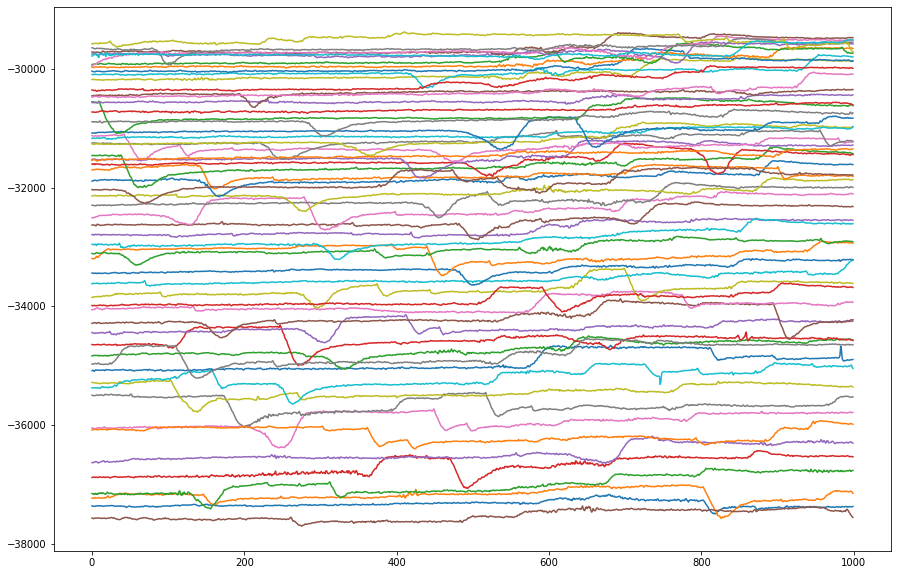

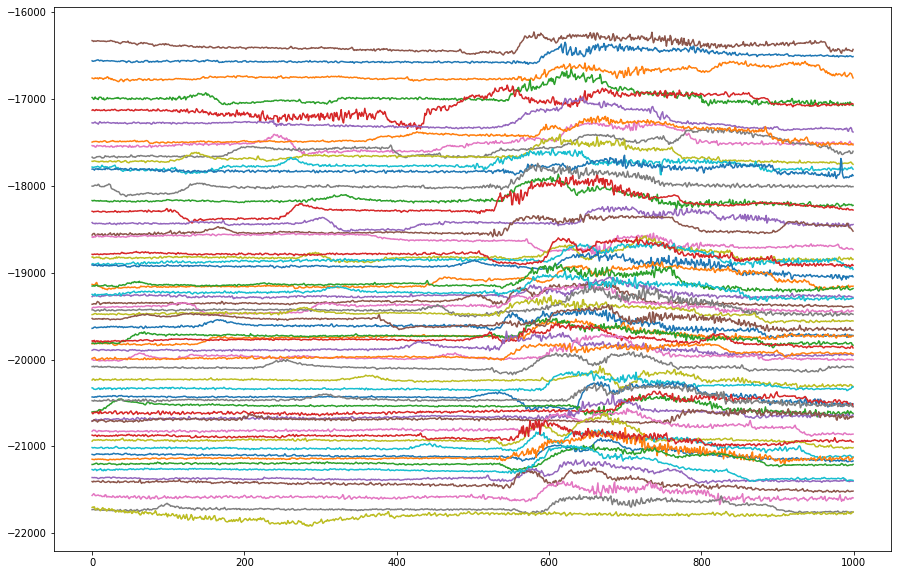

In [6]:
import numpy as np

#specify, what file nr to read
subject = "hain"

with open("./Processed_data/Cheek/{}".format(subject), 'rb') as file:
    cheek_array = np.load(file)
    
with open("./Processed_data/Brow/{}".format(subject), 'rb') as file:
    brow_array = np.load(file)
    
with open("./Processed_data/Decisions/{}".format(subject), 'rb') as file:
    meta = np.load(file)
print(cheek_array.shape)

fig, ax = plt.subplots(figsize=(15,10))

for i in cheek_array:
    ax.plot(i)
fig.show()

fig, ax = plt.subplots(figsize=(15,10))

for i in brow_array:
    ax.plot(i)
fig.show()